In [1]:
!pip install pydub

# Library

In [28]:
import pandas as pd
import numpy as np
import cv2
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import Audio
from multiprocessing import Pool
from pydub import AudioSegment
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, LSTM
from keras.applications import VGG16, ResNet50
from keras.models import Model
from keras.optimizers import Adam

# Dataset

In [3]:
train = pd.read_csv("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/test.tsv", sep="\t")
validated = pd.read_csv("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/validated.tsv", sep="\t")

In [4]:
train.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25361388.mp3,Saya mendengarkan cerita membosankan dari tema...,2,0,NaN,NaN,NaN,NaN,id,NaN
1,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25361422.mp3,halo dunia!,2,0,NaN,NaN,NaN,NaN,id,NaN
2,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25377216.mp3,Sudah makan? sudah sholat...?,2,0,NaN,NaN,NaN,NaN,id,NaN
3,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25378528.mp3,mau pergi kemana hari ini?,2,0,NaN,NaN,NaN,NaN,id,NaN
4,6ac0427a8caef565e3a800e844451a5dde7df70a144fae...,common_voice_id_25378794.mp3,udah keluar hasil testnya?,2,0,NaN,NaN,NaN,NaN,id,NaN


In [5]:
test.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0a4e7e60acc2a6145fc2589e6abb81e41e430cea0611bd...,common_voice_id_23033570.mp3,Maha Suci Allah.,2,0,teens,male,NaN,NaN,id,NaN
1,19285f8e012ad31cad237d53bab348ce59a5cc13684754...,common_voice_id_20425643.mp3,Inilah dunia kecil.,2,1,NaN,NaN,NaN,NaN,id,NaN
2,1d4e1d0cfef0c67c55f809a40973083c61c5fead9d2040...,common_voice_id_32647488.mp3,"Ketika dia sampai stasiun, keretanya telah ber...",2,1,NaN,NaN,NaN,NaN,id,NaN
3,1d5894377419894d75aeb5d430134aba34df922d300479...,common_voice_id_35281925.mp3,Aku hanya melakukan yang selalu kulakukan.,4,0,thirties,male,"medhok,Javanese,East java",NaN,id,NaN
4,2daf5cef3cf47fb84297e7118c2bef7c32fc21bda12bfa...,common_voice_id_27407521.mp3,"Siapa yang terbaik, dia lah yang layak menjadi...",2,0,fourties,male,NaN,NaN,id,NaN


In [6]:
validated.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,0a4e7e60acc2a6145fc2589e6abb81e41e430cea0611bd...,common_voice_id_23033570.mp3,Maha Suci Allah.,2,0,teens,male,NaN,NaN,id,NaN
1,19285f8e012ad31cad237d53bab348ce59a5cc13684754...,common_voice_id_20425643.mp3,Inilah dunia kecil.,2,1,NaN,NaN,NaN,NaN,id,NaN
2,1d4e1d0cfef0c67c55f809a40973083c61c5fead9d2040...,common_voice_id_32647488.mp3,"Ketika dia sampai stasiun, keretanya telah ber...",2,1,NaN,NaN,NaN,NaN,id,NaN
3,1d5894377419894d75aeb5d430134aba34df922d300479...,common_voice_id_35281925.mp3,Aku hanya melakukan yang selalu kulakukan.,4,0,thirties,male,"medhok,Javanese,East java",NaN,id,NaN
4,2daf5cef3cf47fb84297e7118c2bef7c32fc21bda12bfa...,common_voice_id_27407521.mp3,"Siapa yang terbaik, dia lah yang layak menjadi...",2,0,fourties,male,NaN,NaN,id,NaN


# Feature Selection and Missing Value

In [7]:
df_list = [train, test, validated]
df_name = ["Train", "Test", "Validated"]
for i in range(len(df_list)):
  print(df_name[i], "\n")
  print(df_list[i].shape)
  print(df_list[i].isnull().sum(), "\n")
  print("="*20, "\n")

Train 

(4967, 11)
client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age           1930
gender        1930
accents       4967
variant       4967
locale           0
segment       4967
dtype: int64 


Test 

(3630, 11)
client_id        0
path             0
sentence         0
up_votes         0
down_votes       0
age           1342
gender        1341
accents       3456
variant       3630
locale           0
segment       3618
dtype: int64 


Validated 

(25211, 11)
client_id         0
path              0
sentence          0
up_votes          0
down_votes        0
age            5224
gender         5223
accents       24626
variant       25211
locale            0
segment       25068
dtype: int64 




In [8]:
for i in range(len(df_list)):
  df_list[i] = df_list[i][["path", "gender"]]
  df_list[i] = df_list[i].dropna()
  print(df_name[i], "\n")
  print(df_list[i].shape)
  print(df_list[i].isnull().sum(), "\n")
  print("="*20, "\n")

Train 

(3037, 2)
path      0
gender    0
dtype: int64 


Test 

(2289, 2)
path      0
gender    0
dtype: int64 


Validated 

(19988, 2)
path      0
gender    0
dtype: int64 




# Audio Processing and Parallel Computing

In [9]:
def audio_to_spectrogram(mp3_path):
  audio = AudioSegment.from_mp3(mp3_path)
  audio.export('temp_audio.wav', format='wav')
  y, sr = librosa.load('temp_audio.wav')
  spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
  image_path = mp3_path.replace('.mp3', '.png').replace('clips', 'spectrogram')
  spec_min, spec_max = log_spectrogram.min(), log_spectrogram.max()
  normalized_spectrogram = 255 * (log_spectrogram - spec_min) / (spec_max - spec_min)
  normalized_spectrogram = normalized_spectrogram.astype(np.uint8)
  cv2.imwrite(image_path, normalized_spectrogram)

def process_audio(mp3_path):
  path_cek = mp3_path.replace('.mp3', '.png')
  if not os.path.exists("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/spectrogram/" + path_cek):
    audio_to_spectrogram("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/" + mp3_path)
  img = cv2.imread("/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/spectrogram/" + path_cek)
  img = cv2.resize(img, (128, 128))
  return img

df_list[2] = df_list[2].head(2000)
image_list = {}
pool = Pool(processes=30)

for i in range(len(df_list)):
  image_list[df_name[i]] = pool.map(process_audio, df_list[i]["path"])

pool.close()
pool.join()
if os.path.exists('temp_audio.wav'):
  os.remove('temp_audio.wav')

# Image Processing

In [10]:
def labelss(row, lbl):
  li = []
  for i in range(row):
    if lbl[i] == "male":
      li.append(1)
    elif lbl[i] == "female":
      li.append(0)
  return li

train_label = np.array(labelss(len(df_list[0]["gender"]), df_list[0]["gender"].tolist()))
test_label = np.array(labelss(len(df_list[1]["gender"]), df_list[1]["gender"].tolist()))
valid_label = np.array(labelss(len(df_list[2]["gender"]), df_list[2]["gender"].tolist()))
image_list["Train"] = image_list["Train"][:len(train_label)]
image_list["Test"] = image_list["Test"][:len(test_label)]
image_list["Validated"] = image_list["Validated"][:len(valid_label)]

In [11]:
train_images = np.array(image_list["Train"]) / 255
test_images = np.array(image_list["Test"]) / 255
valid_images = np.array(image_list["Validated"]) / 255
train_labels = to_categorical(train_label)
test_labels = to_categorical(test_label)
valid_labels = to_categorical(valid_label)
print("Train Image Shape:", train_images.shape)
print("Test Image Shape:", test_images.shape)
print("Valid Image Shape:", valid_images.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Labels Shape:", test_labels.shape)
print("Valid Labels Shape:", valid_labels.shape)

Train Image Shape: (3037, 128, 128, 3)
Test Image Shape: (2255, 128, 128, 3)
Valid Image Shape: (1969, 128, 128, 3)
Train Labels Shape: (3037, 2)
Test Labels Shape: (2255, 2)
Valid Labels Shape: (1969, 2)


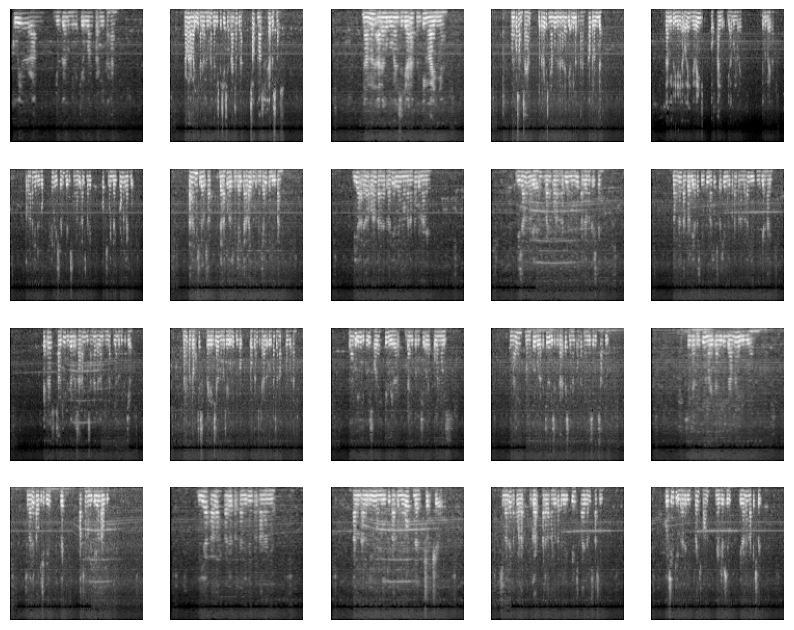

In [12]:
plt.figure(figsize=(10, 10))
for i in range(20):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i])
  plt.axis('off')
plt.show()

# Models

## Simple CNN

In [15]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(128, 128, 3)))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
cnn_model.add(MaxPool2D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(512,activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(256,activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2,activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 127, 127, 16)      208       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 64)       

In [16]:
history = cnn_model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(valid_images, valid_labels))

Epoch 1/5
95/95 [==============================] - 19s 43ms/step - loss: 0.1061 - accuracy: 0.9611 - val_loss: 2.1787 - val_accuracy: 0.5515
Epoch 2/5
95/95 [==============================] - 2s 20ms/step - loss: 0.0196 - accuracy: 0.9970 - val_loss: 2.4015 - val_accuracy: 0.5597
Epoch 3/5
95/95 [==============================] - 2s 19ms/step - loss: 0.0255 - accuracy: 0.9974 - val_loss: 2.0433 - val_accuracy: 0.5637
Epoch 4/5
95/95 [==============================] - 1s 15ms/step - loss: 0.0206 - accuracy: 0.9974 - val_loss: 2.8524 - val_accuracy: 0.4957
Epoch 5/5
95/95 [==============================] - 1s 15ms/step - loss: 0.0196 - accuracy: 0.9974 - val_loss: 2.5334 - val_accuracy: 0.4703


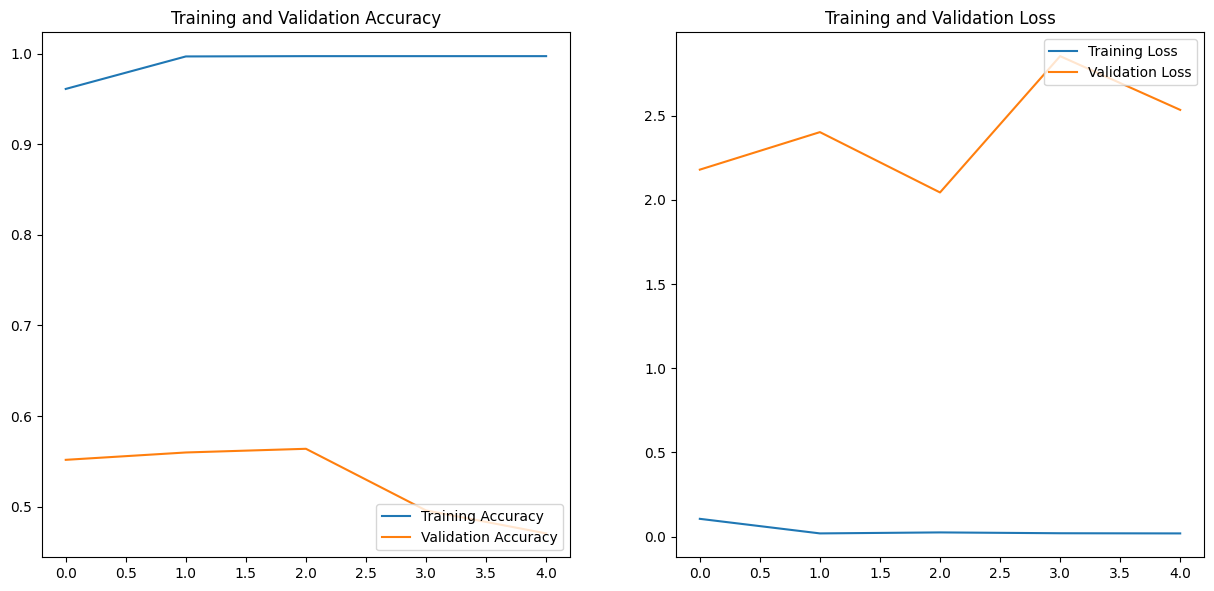

In [17]:
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
%%capture
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

In [19]:
print("Akurasi:", test_acc)

Akurasi: 0.5370288491249084


## VGG16

In [20]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg_model = Sequential()
vgg_model.add(base_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(2, activation='sigmoid'))
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                      

In [21]:
history = vgg_model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(valid_images, valid_labels))

Epoch 1/5
95/95 [==============================] - 37s 266ms/step - loss: 0.0962 - accuracy: 0.9802 - val_loss: 24.1457 - val_accuracy: 0.7638
Epoch 2/5
95/95 [==============================] - 17s 175ms/step - loss: 0.0243 - accuracy: 0.9967 - val_loss: 1.1729 - val_accuracy: 0.7202
Epoch 3/5
95/95 [==============================] - 19s 197ms/step - loss: 0.0214 - accuracy: 0.9974 - val_loss: 5.9551 - val_accuracy: 0.2560
Epoch 4/5
95/95 [==============================] - 19s 197ms/step - loss: 0.0210 - accuracy: 0.9974 - val_loss: 1.3605 - val_accuracy: 0.6917
Epoch 5/5
95/95 [==============================] - 19s 197ms/step - loss: 0.0193 - accuracy: 0.9977 - val_loss: 1.2089 - val_accuracy: 0.7298


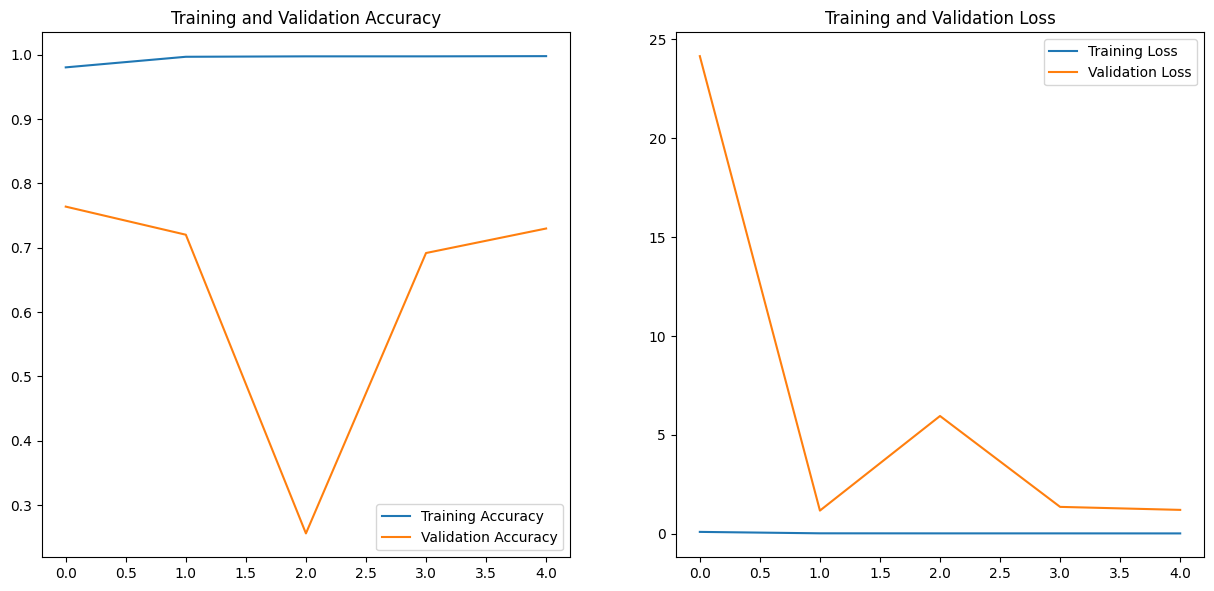

In [22]:
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
%%capture
test_loss, test_acc = vgg_model.evaluate(test_images, test_labels);

In [24]:
print("Akurasi:", test_acc)

Akurasi: 0.7654101848602295


In [142]:
def prediksi(mp3_path, model):
  audio = AudioSegment.from_mp3(mp3_path)
  audio.export('temp_audio.wav', format='wav')
  y, sr = librosa.load('temp_audio.wav')
  spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
  spec_min, spec_max = log_spectrogram.min(), log_spectrogram.max()
  normalized_spectrogram = 255 * (log_spectrogram - spec_min) / (spec_max - spec_min)
  normalized_spectrogram = normalized_spectrogram.astype(np.uint8)
  cv2.imwrite("audio.png", normalized_spectrogram)
  img = np.array([cv2.resize(cv2.imread("audio.png"), (128, 128))])
  pred = np.argmax(model.predict(img))
  if os.path.exists('temp_audio.wav'):
    os.remove('temp_audio.wav')
  if os.path.exists('audio.png'):
    os.remove('audio.png')
  if pred == 1:
    return "male"
  elif pred == 0:
    return "female"

In [143]:
audio = "/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/common_voice_id_27389019.mp3"
Audio(audio)

In [149]:
prediksi(audio, vgg_model)

1/1 [==============================] - 0s 43ms/step


'female'

In [145]:
audio2 = "/content/drive/MyDrive/cv-corpus-14.0-2023-06-23/id/clips/common_voice_id_20900234.mp3"
Audio(audio2)

In [146]:
prediksi(audio2, cnn_model)

1/1 [==============================] - 0s 176ms/step


'male'